In [1]:
import numpy as np
from scipy.stats import genextreme as gev
from scipy.stats import norm
from scipy.integrate import trapz
import matplotlib.pyplot as plt

The question to answer here is whether we can trick ourselves into thinking that data is GEV, when in fact it's log-normal but conditional on several slowly varying predictors.
First we generate the predictors

In [2]:
n_predictors = 3
n_year = 500
time = np.linspace(0, n_year, num=n_year)
periods = np.int_(np.exp(np.random.uniform(low=2, high=5, size=n_predictors)))
print(f"Periods: {periods} years")
phases = np.random.uniform(low=0, high=2*np.pi, size=n_predictors)
predictors = np.array([np.sin(2 * np.pi * time / periods[i] + phases[i]) for i in range(n_predictors)]).T

Periods: [ 9 13 24] years


Let's plot them -- we have here a seasonal cycle plus two longer ones.
For concision we'll just plot the first 100 years

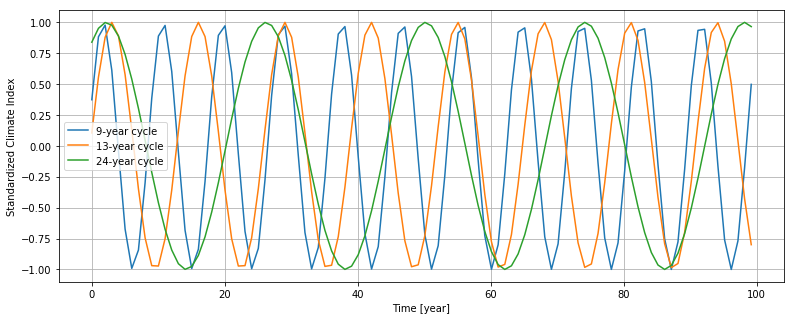

In [3]:
plt.figure(figsize=(13, 5))
for i in range(n_predictors):
    plt.plot(time[0:100], predictors[0:100, i], label='{}-year cycle'.format(periods[i]))
plt.grid()
plt.xlabel('Time [year]')
plt.ylabel('Standardized Climate Index')
plt.legend()
plt.show()

Now we generate the fake observations:

$$
\begin{align*}
    \mu &= \mu_0 + X^T \beta \\
    \sigma &= 0.1 \mu \\
    \log Q &\sim \mathcal{N}(\mu, \sigma)
\end{align*}
$$

where $\beta$ are the (also randomly chosen) dependences on the large-scale climate predictors and $X$ is the notation for these predictors.

In [4]:
amplitudes = np.random.normal(loc=0, scale=0.5, size=n_predictors)
mu0 = 4.0
coeff_var = 0.1
mu = np.repeat(mu0, time.size)
for i in range(n_predictors):
    mu += amplitudes[i] * predictors[:, i]
sigma = coeff_var * mu
sigma[np.where(sigma < 0.1)] = 0.1
observed = np.exp(np.random.normal(loc=mu, scale=sigma))

Once again, let's plot these

/usr/local/miniconda3/envs/PYFloods/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:1902: RuntimeWarning: invalid value encountered in true_divide
  np.sign(c)*(-g3+(g2+2*g2mg12)*g1)/((g2mg12)**(3./2.)))
/usr/local/miniconda3/envs/PYFloods/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:1907: RuntimeWarning: invalid value encountered in true_divide
  (g4+(-4*g3+3*(g2+g2mg12)*g1)*g1)/((g2mg12)**2))
/usr/local/miniconda3/envs/PYFloods/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]


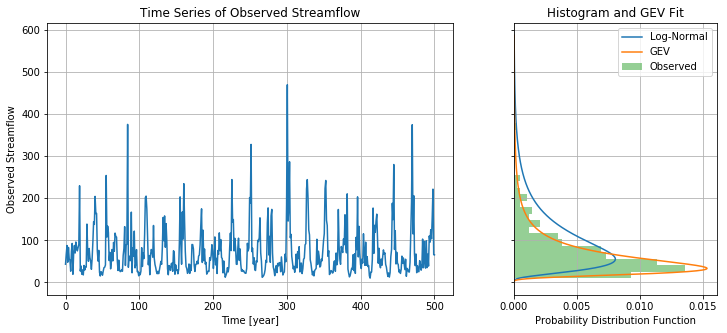

In [5]:
fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5), sharey=True, gridspec_kw = {'width_ratios':[2, 1]})
ax = axes[0]
ax.plot(time, observed)
ax.grid()
ax.set_title('Time Series of Observed Streamflow')
ax.set_xlabel('Time [year]')
ax.set_ylabel('Observed Streamflow')

ax = axes[1]
muhat, sigmahat = norm.fit(np.log(observed))
shapehat, lochat, scalehat = gev.fit(observed)
sflo = np.linspace(0, 1.25 * observed.max(), 1000)
norm_prob = norm.pdf(np.log(sflo), loc=muhat, scale=sigmahat)
norm_prob /= trapz(x=sflo, y=norm_prob)
gev_prob = gev.pdf(sflo, shapehat, scale=scalehat, loc=lochat)
gev_prob /= trapz(x=sflo, y=gev_prob)
ax.plot(norm_prob, sflo, label='Log-Normal')
ax.plot(gev_prob, sflo, label='GEV')
ax.hist(observed, orientation="horizontal", density=True, bins=30, alpha=0.5, label='Observed')
ax.grid()
ax.set_xlabel('Probability Distribution Function')
ax.set_title('Histogram and GEV Fit')
ax.legend()

plt.show()

We can see from the plot here that a GEV distribution fits far better than a log-normal distribution here, and might otherwise be inclined to model the data as GEV.
However, this isn't necessarily necessary and may in fact lead to confusion.

The real question is whether *real-world* data is better represented by a GEV distribution or a condional log-normal distribution.
The answer is probably that it depends on the specific data, and the purpose of this post is just to illustrate how using conditional information can be an alternative to using GEV models.
As always, when working with real data be sure to *check your model* when you make any assumption, including those suggested here!